## Final Project 
## Brainster DS x Parkinson's Disease Specifications

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import partial
import re
import pickle
import joblib
from scipy.stats import skew, kurtosis
from scipy import stats
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix,recall_score,precision_score,roc_curve,auc
from sklearn.metrics import ConfusionMatrixDisplay
from catboost import CatBoostClassifier

In [2]:
df_users = pd.read_csv("df_user.csv")
df_keys = pd.read_csv("df_keys.csv")

In [3]:
hold_by_user =  df_keys[df_keys['Hand'] != 'S'].groupby(['ID', 'Hand'])['HoldTime'].agg(['mean'])
latency_by_user = df_keys[np.in1d(df_keys['Direction'], ['LL', 'LR', 'RL', 'RR'])].groupby(['ID', 'Direction'])['LatencyTime'].agg(['mean'])

In [4]:
hold_by_user_flat = hold_by_user.unstack()
hold_by_user_flat.columns = ['_'.join(col).strip() for col in hold_by_user_flat.columns.values]

In [5]:
latency_by_user_flat = latency_by_user.unstack()
latency_by_user_flat.columns = ['_'.join(col).strip() for col in latency_by_user_flat.columns.values]

In [6]:
combined = pd.concat([hold_by_user_flat, latency_by_user_flat], axis=1)

In [7]:
full_set = pd.merge(combined.reset_index(), df_users[['ID', 'Parkinsons']], on='ID')


In [8]:
full_set['Parkinsons'] = full_set['Parkinsons'].astype(int)

In [9]:
X = full_set.drop(columns=['Parkinsons', 'ID'], axis=1)
y = full_set['Parkinsons']

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=42)
from sklearn.model_selection import cross_validate
rf.fit(X, y)
cv = cross_val_score(rf, X, y, cv=5)
print(cv.mean())

0.46911764705882353


In [11]:
import shap

In [12]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X)

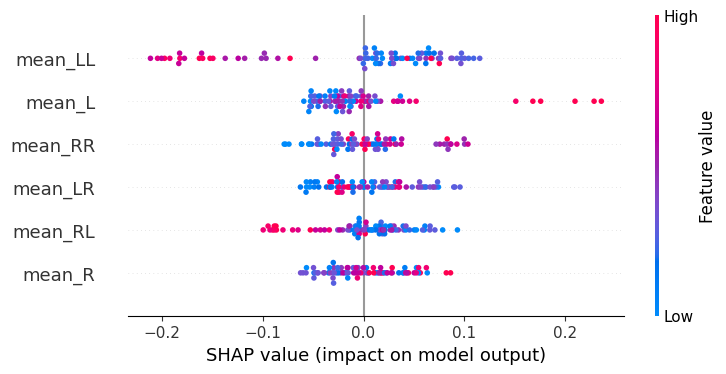

In [13]:
shap.initjs()
shap.plots.beeswarm(shap_values[:,:,1], max_display=27)

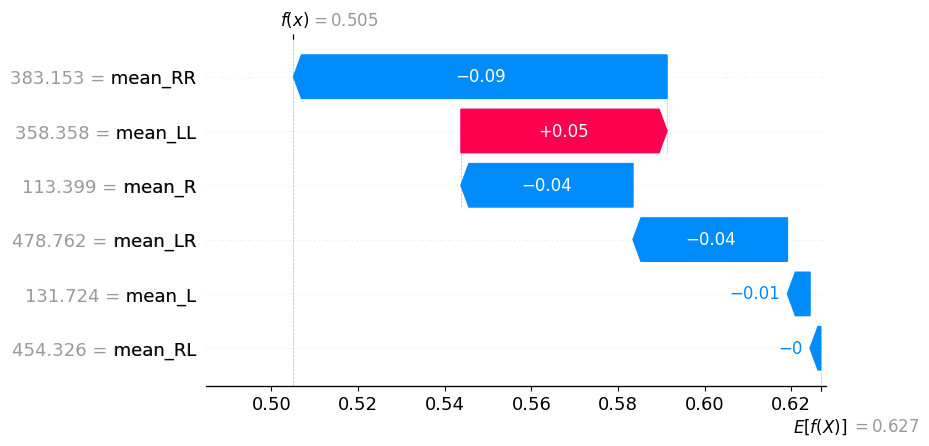

In [15]:
shap.plots.waterfall(shap_values[6,:,0], max_display=27)